<a href="https://colab.research.google.com/github/ffer200395/ML-course/blob/main/3_NLP-Rese%C3%B1as.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 5.2 MB/s 
     |████████████████████████████████| 240 kB 54.4 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=e0e88945e8b33778aea19be7814e668beebb54fe7dd7cc5b56d1da4549f05532
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [ ]:
!python -m spacy download en_core_web_sm

2022-11-28 16:13:18.464249: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import regex as re
import stanza
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sn

import pickle

# Especificamos la ruta en la que estamos trabajando y montamos Google drive en la sesiónpara cargar el dataset que vamos a tratar

In [ ]:
# Path
path = '/content/gdrive/MyDrive/Colab Notebooks/Formación Python y ML/prácticas'
# Mount drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(path+'/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df = df.groupby('sentiment').sample(n=5000)

# Seleccionamos un texto para aplicar un preprocesado paso a paso

In [ ]:
df['review'].values[0]

'As an impressionable 10 year old, I liked the "love conquers all" philosophy of the 70s sitcom "Bridget Loves Bernie." I did understand the controversy, which was about the romantic complications between a Jewish cab driver (David Birney) and an Irish Catholic school teacher (Meredith Baxter) and both sets of parents (Harold J. Stone and Bibi Osterwald as Bernie\'s parents; Audra Lindley and David Doyle as Bridget\'s parents) who have issues with the young couple\'s interfaith marriage.<br /><br />Looking at the show now with years of personal life experiences, I am amazed that the show was even a success for one, albeit, highly-rated season. Created by veteran TV writer Bernard Slade, who a few years after the show\'s cancellation would write the successful play "Same Time, Next Year", "Bridget Loves Bernie" was a very light, superficial comedy that collapsed under its own airy weight.<br /><br />There was no denying the real-life chemistry between Birney and Baxter. But, in later ye

In [ ]:
# Guardamos el texto que vamos a tratar en la variable texto
texto = df['review'].values[0]

In [ ]:
print(texto.lower())

as an impressionable 10 year old, i liked the "love conquers all" philosophy of the 70s sitcom "bridget loves bernie." i did understand the controversy, which was about the romantic complications between a jewish cab driver (david birney) and an irish catholic school teacher (meredith baxter) and both sets of parents (harold j. stone and bibi osterwald as bernie's parents; audra lindley and david doyle as bridget's parents) who have issues with the young couple's interfaith marriage.<br /><br />looking at the show now with years of personal life experiences, i am amazed that the show was even a success for one, albeit, highly-rated season. created by veteran tv writer bernard slade, who a few years after the show's cancellation would write the successful play "same time, next year", "bridget loves bernie" was a very light, superficial comedy that collapsed under its own airy weight.<br /><br />there was no denying the real-life chemistry between birney and baxter. but, in later years, 

In [ ]:
# Paso 1 pasamos a minúscula
texto = texto.lower()

In [ ]:
re.sub('<br /><br />',' ',texto)
re.sub('[^a-z]+', ' ', texto)

'as an impressionable year old i liked the love conquers all philosophy of the s sitcom bridget loves bernie i did understand the controversy which was about the romantic complications between a jewish cab driver david birney and an irish catholic school teacher meredith baxter and both sets of parents harold j stone and bibi osterwald as bernie s parents audra lindley and david doyle as bridget s parents who have issues with the young couple s interfaith marriage br br looking at the show now with years of personal life experiences i am amazed that the show was even a success for one albeit highly rated season created by veteran tv writer bernard slade who a few years after the show s cancellation would write the successful play same time next year bridget loves bernie was a very light superficial comedy that collapsed under its own airy weight br br there was no denying the real life chemistry between birney and baxter but in later years both actors have shown that they are better ac

In [ ]:
# Paso 2 aplicamos una expresión regular que solo deja letras
texto = re.sub('<br /><br />',' ',texto)
texto = re.sub('[^a-z]+', ' ', texto)

In [ ]:
# Paso 3 craemos un listado de ejemplo de stopwords y una función que filtra el texto de modo que lo deja sin las stopwords y elimia palabras con menos de 3 caracteres
ls_sw = ['the','of','that','these','those','a','an','this']
def remove_stopwords(texto, ls_stopwords):
  ls_words = texto.split(' ')
  ls_words_res = list()
  # Iterar sobre cada palabra del texto
  for word in ls_words:
    # Si no está en el listado de palabras inútiles y su longitud es mayor de 1 guardala
    if (word not in ls_stopwords) and len(word)>=3:
      ls_words_res.append(word)
  return ' '.join(ls_words_res)

In [ ]:
remove_stopwords(texto, ls_stopwords=ls_sw)

'impressionable year old liked love conquers all philosophy sitcom bridget loves bernie did understand controversy which was about romantic complications between jewish cab driver david birney and irish catholic school teacher meredith baxter and both sets parents harold stone and bibi osterwald bernie parents audra lindley and david doyle bridget parents who have issues with young couple interfaith marriage looking show now with years personal life experiences amazed show was even success for one albeit highly rated season created veteran writer bernard slade who few years after show cancellation would write successful play same time next year bridget loves bernie was very light superficial comedy collapsed under its own airy weight there was denying real life chemistry between birney and baxter but later years both actors have shown they are better actors other projects birney his short lived role elsewhere and baxter family and family ties here they were trying breathe life show nee

In [ ]:
texto = remove_stopwords(texto, ls_stopwords=ls_sw)

In [ ]:
# Para obtener el lemma de las palabras
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')
doc = nlp(texto)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
# Dado un objeto nlp y un texto devuelve el mismo texto pero con sus palabras lemmatizadas (útil para reducir el número de palabras)
def lemmatizer(texto,nlp):
  doc = nlp(texto)
  ls_words = [word.lemma.lower() for word in doc.sentences[0].words]
  return ' '.join(ls_words)

In [ ]:
lemmatizer(texto,nlp)

'impressionable year old like love conquer all philosophy sitcom bridget love bernie do understand controversy which be about romantic complication between jewish cab driver david birney and irish catholic school teacher meredith baxter and both set parent harold stone and bibi osterwald bernie parent audra lindley and david doyle bridget parent who have issue with young couple interfaith marriage look show now with year personal life experience amaze show be even success for one albeit highly rate season create veteran writer bernard slade who few year after show cancellation would write successful play same time next year bridget love bernie be very light superficial comedy collapse under its own airy weight there be deny real life chemistry between birney and baxter but late year both actor have show they be good actor other project birney he short live role elsewhere and baxter family and family tie here they be try breathe life show need ed much gritter comic edge which might have

In [ ]:
texto = lemmatizer(texto,nlp)

In [ ]:
# Eliminamos espacios adicionales
re.sub(r'\s+', ' ', texto)

'impressionable year old like love conquer all philosophy sitcom bridget love bernie do understand controversy which be about romantic complication between jewish cab driver david birney and irish catholic school teacher meredith baxter and both set parent harold stone and bibi osterwald bernie parent audra lindley and david doyle bridget parent who have issue with young couple interfaith marriage look show now with year personal life experience amaze show be even success for one albeit highly rate season create veteran writer bernard slade who few year after show cancellation would write successful play same time next year bridget love bernie be very light superficial comedy collapse under its own airy weight there be deny real life chemistry between birney and baxter but late year both actor have show they be good actor other project birney he short live role elsewhere and baxter family and family tie here they be try breathe life show need ed much gritter comic edge which might have

In [ ]:
texto = re.sub(r'\s+', ' ', texto)

# A continuación aplicamos un preprocesado simple a todos los textos

In [ ]:
# Versión simple
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Spacy nos permite realizar muchos de los pasos anteriores en pocas líneas
def normalize(text):
    doc = nlp(text)
    words = [t.orth_ for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if len(t) >= 3 and  t.isalpha()]
    return ' '.join(lexical_tokens)

In [ ]:
# Guardamos el texto normalizado en una columna llamada review_norm
tqdm.pandas()
df['review_norm'] = df['review'].progress_apply(normalize)

100%|██████████| 10000/10000 [08:28<00:00, 19.65it/s]


In [ ]:
# Convertimos el texto en una matriz de conteos de palabras
vectorizer = CountVectorizer(max_df=.8, min_df=.05, stop_words='english')
X = vectorizer.fit_transform(df['review_norm'])

In [ ]:
# Visualizamos las palabras que han quedado en nuestro corpus
vectorizer.get_feature_names_out()

array(['absolutely', 'acting', 'action', 'actor', 'actors', 'actually',
       'american', 'audience', 'away', 'awful', 'bad', 'based',
       'beautiful', 'believe', 'best', 'better', 'big', 'bit', 'black',
       'book', 'boring', 'boy', 'budget', 'called', 'came', 'camera',
       'case', 'cast', 'certainly', 'character', 'characters', 'classic',
       'come', 'comedy', 'comes', 'completely', 'couple', 'course', 'day',
       'dead', 'death', 'definitely', 'dialogue', 'different', 'director',
       'dvd', 'early', 'effects', 'end', 'ending', 'enjoy', 'especially',
       'excellent', 'face', 'fact', 'family', 'fan', 'far', 'father',
       'feel', 'felt', 'film', 'films', 'friend', 'friends', 'fun',
       'funny', 'gets', 'getting', 'girl', 'given', 'goes', 'going',
       'good', 'got', 'great', 'guy', 'half', 'hard', 'having', 'head',
       'help', 'high', 'hollywood', 'home', 'hope', 'horror', 'house',
       'idea', 'instead', 'interesting', 'job', 'john', 'kind', 'know',
  

In [ ]:
# La variable sentiment (la que queremos predecir) la pasamos a formato numérico con label encoder
le = preprocessing.LabelEncoder()
df['y'] = le.fit_transform(df['sentiment'])

In [ ]:
X.shape

(10000, 222)

In [ ]:
# Reducimos la dimensión de nuestros datos de 222 variables a 150
svd = TruncatedSVD(n_components=150)
svd.fit(X)

TruncatedSVD(n_components=150)

In [ ]:
sum(svd.explained_variance_ratio_)

0.8908050992594759

In [ ]:
X_svd = svd.transform(X)

In [ ]:
X_svd.shape

(10000, 150)

In [ ]:
# Rompemos el dataset en los conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_svd, df['y'], test_size=0.2, random_state=42)

In [ ]:
# Probamos una librería que testea diferentes algoritmos sobre nuestros datos
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, predictions=True)

In [ ]:
X_train#.toarray()

array([[ 7.95319073, -5.8472738 , -1.74857123, ..., -0.16617899,
         0.21557325, -0.21180474],
       [ 1.92296095,  1.41312995, -0.20593727, ..., -0.19918273,
         0.20081443,  0.31622019],
       [ 1.12751337, -0.7882459 ,  0.13524402, ...,  0.41532975,
         0.29382889, -0.15828254],
       ...,
       [ 2.63402189,  2.18958692, -0.17777855, ..., -0.02343501,
         0.10097365, -0.15828493],
       [ 4.5132383 , -2.30536799,  0.28679463, ..., -0.07986827,
        -0.53673279,  0.13296902],
       [ 3.26311527, -0.92240224,  0.64712924, ..., -0.06905992,
        -0.23067853, -0.21146731]])

In [ ]:
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [01:48<00:00,  3.74s/it]


In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.80,0.80,0.80,0.80,5.70
CalibratedClassifierCV,0.80,0.80,0.80,0.80,20.91
LogisticRegression,0.80,0.80,0.80,0.80,0.17
SVC,0.79,0.79,0.79,0.79,9.59
LinearDiscriminantAnalysis,0.78,0.78,0.78,0.78,0.39
RidgeClassifierCV,0.78,0.78,0.78,0.78,0.30
RidgeClassifier,0.78,0.78,0.78,0.78,0.12
NearestCentroid,0.78,0.78,0.78,0.78,0.10
NuSVC,0.78,0.78,0.78,0.78,11.05


In [ ]:
predictions

,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,1,0,0,1,0,...,1,1,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,0,1,1,1,1,0,1,1,...,1,1,1,0,1,1,0,1,1,0
1996,1,1,1,0,1,1,1,1,1,1,...,0,0,1,1,0,0,1,0,1,1
1997,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Aplicamos random forest
from sklearn.ensemble import RandomForestClassifier
est = RandomForestClassifier()
parameters = {'n_estimators':range(10,110,10)}
gs = GridSearchCV(est, parameters,n_jobs=-1,scoring='f1', verbose=2)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': range(10, 110, 10)}, scoring='f1',
             verbose=2)

In [ ]:
gs.best_score_

0.7285183318615165

In [ ]:
# Predecimos con random forest los datos de test
yhat = gs.predict(X_test)

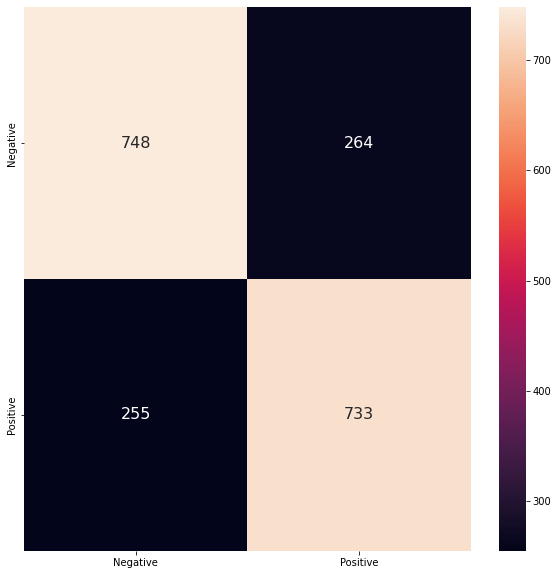

In [ ]:
# Mostramos los resultados en una matriz de confusión que nos indica los vp,vn,fp,fn 
cm=confusion_matrix(y_test, yhat)
df_cm = pd.DataFrame(cm,index=['Negative','Positive'],columns = ['Negative','Positive'])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')

In [ ]:
# Medimos la precisión y la exactitud
print(f'Precisión: {np.round(precision_score(y_test,yhat),2)}')

Precisión: 0.74


In [ ]:
print(f'Accuracy: {np.round(accuracy_score(y_test,yhat),2)}')

Accuracy: 0.74


In [ ]:
# Probamos con una nueva frase y comprobamos la respuesta dada por el modelo
new_review = 'The movie was so bad bad and awful'

In [ ]:
new_review_norm = normalize(new_review)
new_review_norm

'movie bad bad awful'

In [ ]:
new_review_vect = vectorizer.transform(np.array([new_review_norm]))

In [ ]:
new_review_svd = svd.transform(new_review_vect)

In [ ]:
new_review_vect.todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
new_review_svd

array([[ 7.77893543e-01,  7.56761639e-01, -2.48144700e-01,
         2.72951267e-01,  8.76755851e-01, -6.72937082e-01,
         1.03085436e+00, -1.38308912e-01,  5.52702271e-01,
         2.93644692e-01,  3.44841202e-01,  1.89712086e-01,
        -6.12785382e-01,  1.64276542e-02,  3.71504810e-01,
        -2.85056882e-01,  1.69993190e-02, -5.10574033e-02,
         8.66884702e-02,  1.94440416e-01, -7.58402400e-03,
        -2.95232887e-02,  4.51113020e-02, -1.88725847e-01,
        -3.68126760e-02,  2.44622384e-01, -9.05689891e-02,
        -3.08827633e-02,  1.19980851e-03, -1.49845578e-01,
        -2.28470074e-01, -3.98058203e-02,  8.71043981e-02,
        -3.77328223e-02,  4.85831051e-02, -1.29779942e-02,
         2.91583318e-02, -6.84567757e-02, -1.09769764e-01,
         3.78567651e-02, -7.23481111e-02,  2.90469202e-02,
         6.46943114e-02, -6.97134965e-03, -4.38413525e-02,
         2.83841093e-02,  7.13218853e-03, -4.12910330e-03,
        -1.92801310e-02,  7.19664835e-02, -1.51025613e-0

In [ ]:
gs.predict_proba(new_review_svd)

array([[0.96, 0.04]])

In [ ]:
# Guardamos y cargamos el modelo
with open(path+'/gs.pickle', 'wb') as f:
    pickle.dump(gs, f)

In [ ]:
with open(path+'/gs.pickle','rb') as f:
    loaded_obj = pickle.load(f)

In [ ]:
# Predecimos las probabilidades de la nueva reseña
loaded_obj.predict_proba(new_review_svd)

array([[0.96, 0.04]])